#Import Library

In [1]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import nltk
import tensorflow as tf

from io import StringIO
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Loading Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Path file hasil scraping Shopee di Google Drive
csv_path = '/content/drive/MyDrive/Dicoding/Project Analisis Sentimen/shopee_reviews.csv'

# Load data ke DataFrame
df = pd.read_csv(csv_path)
df.head()

Mounted at /content/drive


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,3eb0260c-4c79-4006-9838-60c8b32d6802,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kalo bisa paket² yg banyak di bagi atau di ali...,1,188,3.47.39,2025-04-08 07:44:17,"Hi kak Fardeanto Palapa , maaf ya sudah buat k...",2025-04-08 08:27:09,3.47.39
1,66ff3e08-dfc0-475a-afe0-8afc5dd5176e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sorry, kenapa ya setiap membatalkan pesanan/di...",1,32,3.47.39,2025-04-09 17:17:09,"Hai kak patimura, maaf ya trkait pmbayaran COD...",2025-04-09 18:24:58,3.47.39
2,9431a5a1-a6d7-4a8a-9e3e-b3f09a5704b2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Edit: Aplikasi sudah terbaru di v3.47.39. user...,2,85,3.47.39,2025-04-07 17:31:41,Hai kak maaf udh bikin ga nyaman terkait kenda...,2025-04-07 17:09:59,3.47.39
3,1f7d7626-cc85-467e-b5a5-96853c5a5a7a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tolong shopee tulisannya jangan terlalu kecil ...,2,41,3.47.39,2025-04-07 18:29:20,Hai kak maaf udh bikin ga nyaman terkait kenda...,2025-04-07 19:25:40,3.47.39
4,54df2b65-5871-472a-b37a-c2dd32bb35c8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"tolong jika status pesanan sudah ""Dalam pengan...",5,981,3.47.39,2025-04-07 04:32:26,"Hai kak Dide Naufal, maaf ya buat kamu gak nya...",2025-04-07 05:20:14,3.47.39


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              11000 non-null  object
 1   userName              11000 non-null  object
 2   userImage             11000 non-null  object
 3   content               11000 non-null  object
 4   score                 11000 non-null  int64 
 5   thumbsUpCount         11000 non-null  int64 
 6   reviewCreatedVersion  10999 non-null  object
 7   at                    11000 non-null  object
 8   replyContent          9830 non-null   object
 9   repliedAt             9830 non-null   object
 10  appVersion            10999 non-null  object
dtypes: int64(2), object(9)
memory usage: 945.4+ KB


# Preprocessing Text

In [5]:
# Menghapus nilai null dan duplikat
df = df.dropna(subset=['content'])
df.drop_duplicates(subset=['content'], inplace=True)

In [6]:
clean_df = df.copy()

In [7]:
# Membersihkan teks dari karakter atau simbol yang tidak diperlukan
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # menghapus mention (@username)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # menghapus hashtag (#tag)
    text = re.sub(r'RT[\s]', '', text)         # menghapus retweet (RT)
    text = re.sub(r"http\S+", '', text)        # menghapus link
    text = re.sub(r'[0-9]+', '', text)         # menghapus angka
    text = re.sub(r'[^\w\s]', '', text)        # menghapus simbol atau tanda baca

    text = text.replace('\n', ' ')             # mengganti newline dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # menghapus tanda baca
    text = text.strip()                        # menghapus spasi di awal dan akhir
    return text

# Mengubah semua huruf menjadi huruf kecil
def casefoldingText(text):
    return text.lower()

# Mengganti kata tidak baku atau slang dengan padanan kata bakunya
def normalizeText(text, slangwords):
    words = text.split()
    normalized_words = [slangwords[word] if word in slangwords else word for word in words]
    return ' '.join(normalized_words)

# Memecah kalimat menjadi daftar kata (token)
def tokenizingText(text):
    return word_tokenize(text)

# Menghapus kata-kata umum yang tidak memiliki makna penting (stopwords)
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian') + stopwords.words('english'))
    tambahan_stopwords = ['iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', "di", "ga", "ya", "gaa", "loh", "kah", "woi", "woii", "woy"]
    listStopwords.update(tambahan_stopwords)

    filtered = [word for word in text if word not in listStopwords]
    return filtered

# Mengubah kata menjadi bentuk dasarnya (stemming)
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Menggabungkan kembali daftar kata menjadi kalimat
def toSentence(list_words):
    return ' '.join(list_words)

In [8]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "jelekkkkkk": "jelek", "atran":"antrian", "pliss":"please", "ngeleg":"ngelag", "dihilangkandi":"dihilangkan di"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [9]:
# Membersihkan teks
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata umum
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

# Labeling

In [10]:
import csv

# Ambil Lexicon Positif
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Gagal mengambil lexicon positif")

In [11]:
# Ambil Lexicon Negatif
lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Gagal mengambil lexicon negatif")

# Tambahkan kata negatif tambahan (slang & umum)
extra_neg = {
    'jelek': -1, 'buruk': -1, 'gagal': -1, 'lelet': -1, 'parah': -1,
    'bohong': -1, 'rusak': -1, 'mengecewakan': -1, 'tidak': -1,
    'nggak': -1, 'gak': -1, 'ga': -1, 'lemot': -1, 'batal': -1,
    'hilang': -1, 'lambat': -1, 'menyebalkan': -1, 'error': -1,
    'ribet': -1, 'salah': -1, 'ngelag': -1, 'mencurigakan': -1, 'kecewa': -1, 'ngeleg': -1, 'kecewanya': -1, 'jelekkk': -1,
}
lexicon_negative.update(extra_neg)

In [13]:
def sentiment_analysis_lexicon_indonesia(text):

    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity=''

    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [16]:
from sklearn.utils import resample
import random

# Hitung kembali polaritas
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]

# Cek distribusi awal
print("Distribusi sebelum balancing:")
print(clean_df['polarity'].value_counts())

# Pisahkan tiap kelas
df_positive = clean_df[clean_df['polarity'] == 'positive']
df_negative = clean_df[clean_df['polarity'] == 'negative']
df_neutral  = clean_df[clean_df['polarity'] == 'neutral']

# Hitung jumlah awal tiap kelas
n_pos = len(df_positive)
n_neg = len(df_negative)
n_neu = len(df_neutral)

# Tentukan jumlah target yang masuk akal (maks 3x dari kelas aslinya)
def get_target(n, max_limit=None):
    upper = min(n * 3, max_limit) if max_limit else n * 3
    lower = int(n * 1.5)
    lower = min(lower, upper)
    return random.randint(lower, upper)

max_target = max(n_pos, n_neg) + 500

target_positive = get_target(n_pos, max_limit=max_target)
target_negative = get_target(n_neg, max_limit=max_target)
target_neutral  = get_target(n_neu, max_limit=max_target)

# Oversample (replace=True karena mungkin jumlah asli < target)
df_positive_balanced = resample(df_positive, replace=True, n_samples=target_positive, random_state=42)
df_negative_balanced = resample(df_negative, replace=True, n_samples=target_negative, random_state=42)
df_neutral_balanced  = resample(df_neutral,  replace=True, n_samples=target_neutral,  random_state=42)

# Gabungkan semua
balanced_df = pd.concat([df_positive_balanced, df_negative_balanced, df_neutral_balanced])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Lihat hasil akhir
print("\nDistribusi setelah balancing:")
print(balanced_df['polarity'].value_counts())
print(f"\nTotal sampel setelah balancing: {len(balanced_df)}")

Distribusi sebelum balancing:
polarity
positive    5505
negative    4878
neutral      617
Name: count, dtype: int64

Distribusi setelah balancing:
polarity
positive    6005
negative    6005
neutral     1685
Name: count, dtype: int64

Total sampel setelah balancing: 13695


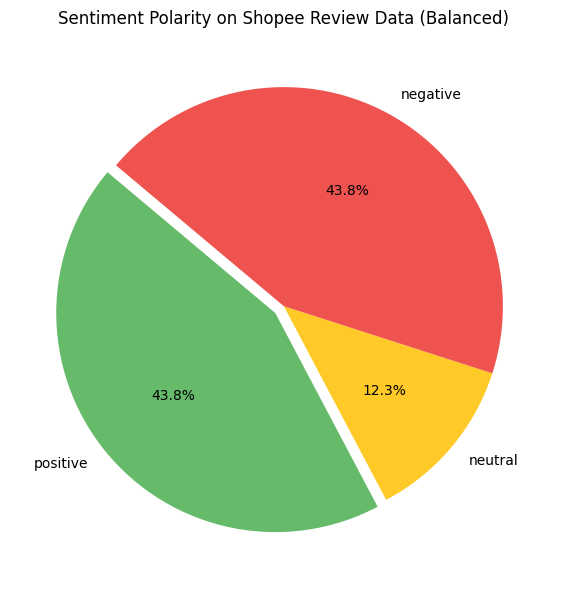

<ipython-input-17-e92ca9d5fe89>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x=labels, y=sizes, palette=colors)


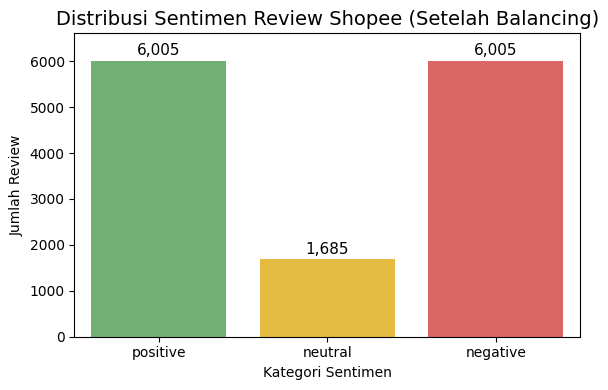

In [17]:
# Hitung jumlah masing-masing sentimen dari data setelah balancing
sentiment_counts = balanced_df['polarity'].value_counts()
labels = ['positive', 'neutral', 'negative']
sizes = [sentiment_counts.get(label, 0) for label in labels]

# Warna tetap dan konsisten
colors = ['#66bb6a', '#ffca28', '#ef5350']  # Hijau, Kuning, Merah
explode = [0.05 if label == 'positive' else 0 for label in labels]

# Pie Chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    explode=explode,
    colors=colors,
    startangle=140,
    textprops={'fontsize': 10}
)
ax.set_title('Sentiment Polarity on Shopee Review Data (Balanced)', fontsize=12)
plt.tight_layout()
plt.show()

# Bar Chart
plt.figure(figsize=(6, 4))
bar = sns.barplot(x=labels, y=sizes, palette=colors)

# Tambahkan label pada setiap bar
for i, val in enumerate(sizes):
    plt.text(i, val + max(sizes)*0.01, f"{val:,}", ha='center', va='bottom', fontsize=11)

plt.title('Distribusi Sentimen Review Shopee (Setelah Balancing)', fontsize=14)
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah Review')
plt.ylim(0, max(sizes) + max(sizes)*0.1)
plt.tight_layout()
plt.show()

## Eksplorasi Label

In [18]:
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# Atur agar teks bisa tampil panjang
pd.set_option('display.max_colwidth', 3000)

# Gunakan data setelah balancing
df = balanced_df

# Filter dan tampilkan review positif
positive_reviews = df[df['polarity'] == 'positive']
positive_reviews = positive_reviews[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
positive_reviews = positive_reviews.sort_values(by='polarity_score', ascending=False).reset_index(drop=True)
positive_reviews.index += 1

# Filter dan tampilkan review negatif
negative_reviews = df[df['polarity'] == 'negative']
negative_reviews = negative_reviews[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
negative_reviews = negative_reviews.sort_values(by='polarity_score', ascending=True).head(10).reset_index(drop=True)
negative_reviews.index += 1

# Filter dan tampilkan review netral
neutral_reviews = df[df['polarity'] == 'neutral']
neutral_reviews = neutral_reviews[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
neutral_reviews = neutral_reviews.sort_values(by='polarity_score', ascending=True).head(10).reset_index(drop=True)
neutral_reviews.index += 1

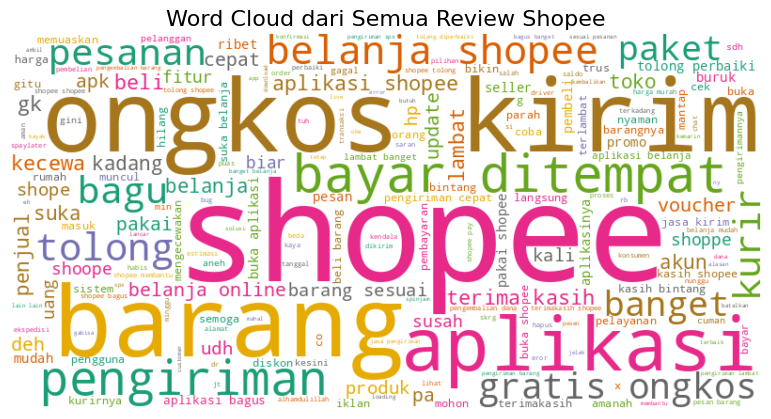

In [19]:
# Fungsi untuk menampilkan WordCloud
def tampilkan_wordcloud(data_kata, judul):
    semua_kata = ' '.join([' '.join(kalimat) for kalimat in data_kata])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate(semua_kata)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(judul, fontsize=16)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# WordCloud per kategori
tampilkan_wordcloud(df['text_stopword'], 'Word Cloud dari Semua Review Shopee')

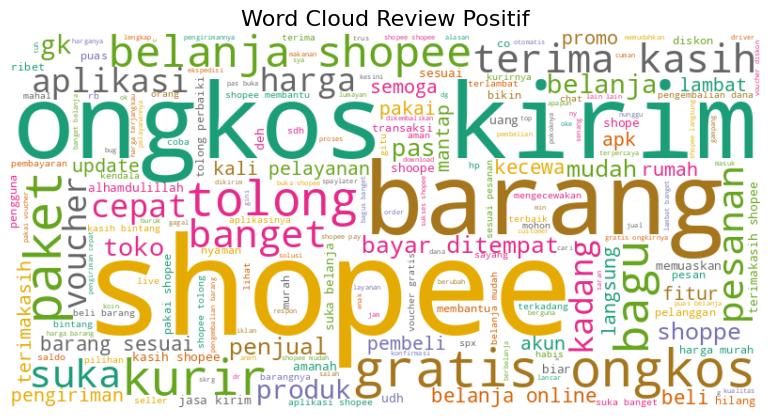

In [20]:
tampilkan_wordcloud(positive_reviews['text_stopword'], 'Word Cloud Review Positif')

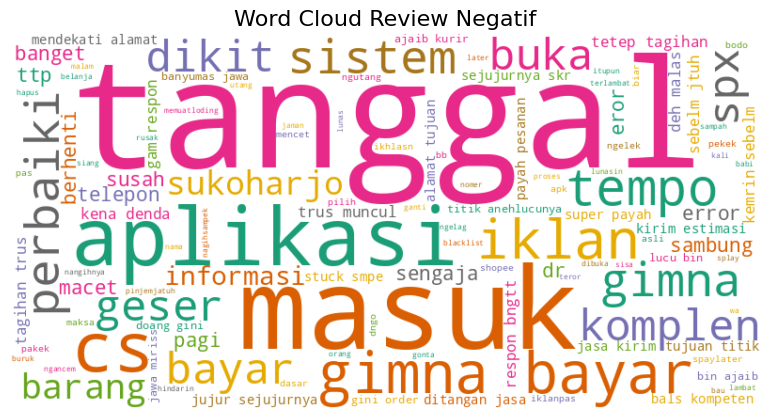

In [21]:
tampilkan_wordcloud(negative_reviews['text_stopword'], 'Word Cloud Review Negatif')

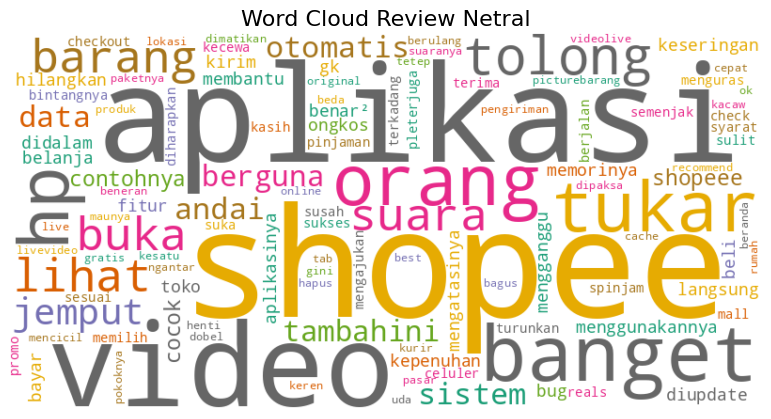

In [22]:
tampilkan_wordcloud(neutral_reviews['text_stopword'], 'Word Cloud Review Netral')

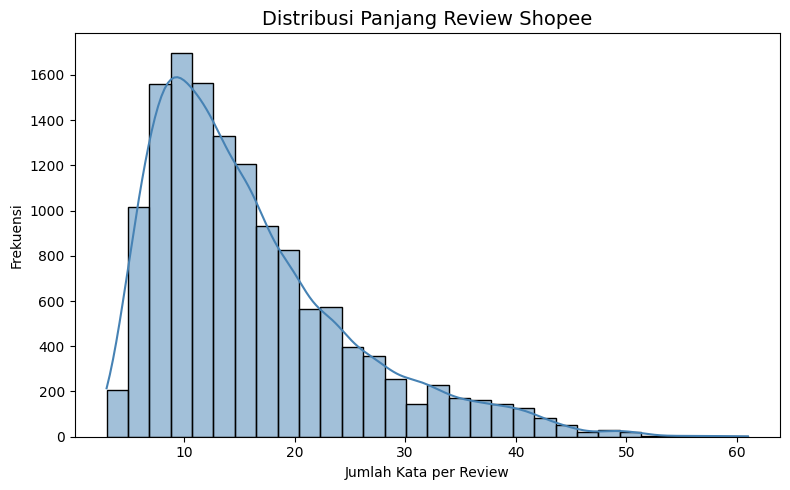

In [23]:
# Distribusi panjang teks
df['text_length'] = df['text_akhir'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(df['text_length'], bins=30, kde=True, color='steelblue')
plt.title('Distribusi Panjang Review Shopee', fontsize=14)
plt.xlabel('Jumlah Kata per Review')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

<ipython-input-24-ef3891d05a47>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_tfidf, x='jumlah', y='kata', palette='viridis')


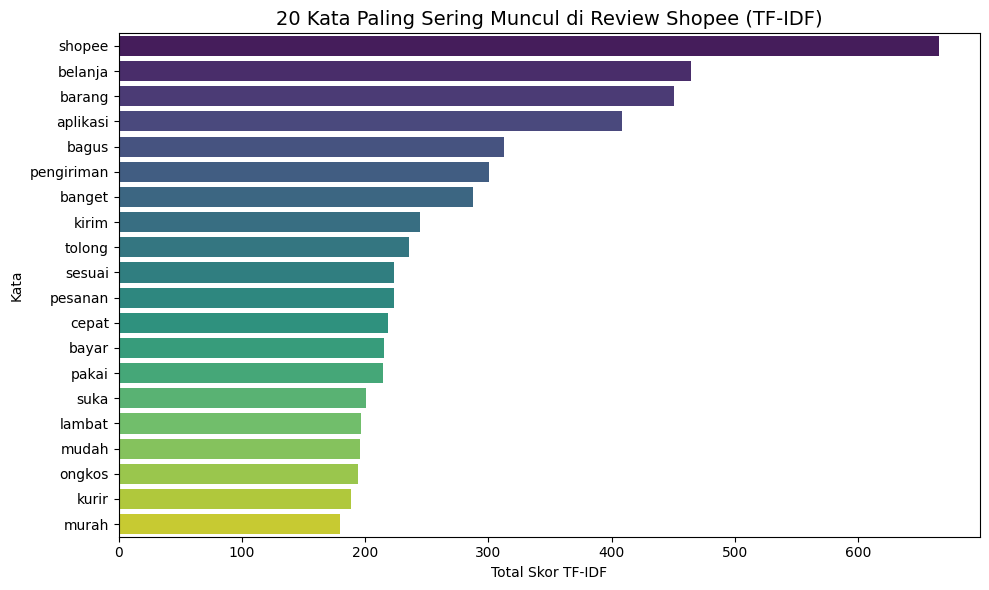

In [24]:
# TF-IDF untuk seluruh teks
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

top_tfidf = tfidf_df.sum().reset_index(name='jumlah')
top_tfidf.columns = ['kata', 'jumlah']
top_tfidf = top_tfidf.sort_values(by='jumlah', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_tfidf, x='jumlah', y='kata', palette='viridis')
plt.title('20 Kata Paling Sering Muncul di Review Shopee (TF-IDF)', fontsize=14)
plt.xlabel('Total Skor TF-IDF')
plt.ylabel('Kata')
plt.tight_layout()
plt.show()

# Pelatihan Model

In [25]:
# Gunakan balanced_df untuk training
df_train = balanced_df.copy()

# Encoding label
label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['polarity'])  # positive=2, neutral=1, negative=0 misalnya

# Simpan untuk inference nanti
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
inverse_label_map = {v: k for k, v in label_map.items()}

print("Label mapping:", label_map)

Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


## Skema 1: LSTM, Split 80/20

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler

# Data Preparation
texts = df_train["text_akhir"].astype(str).values
labels = df_train["polarity"].values

# Label Encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=300)

# Oversampling untuk menangani kelas tidak seimbang
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(padded_sequences, encoded_labels)
y_resampled_cat = to_categorical(y_resampled)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled_cat, test_size=0.2, random_state=42
)

# Hitung class_weight dari data hasil oversampling
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_resampled),
    y=y_resampled
)
class_weights_dict = dict(enumerate(class_weights))

# LSTM Model
model = Sequential([
    Embedding(input_dim=20000, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    BatchNormalization(),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='tanh'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

# Callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    verbose=2,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

# Evaluasi
train_acc_1 = history.history['accuracy'][-1]

# Prediksi & Evaluasi Akurat
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
test_acc_1 = accuracy_score(y_true_classes, y_pred_classes)

# Output Evaluasi
print("=== Evaluasi Skema Pelatihan LSTM ===")
print("Train Accuracy :", train_acc_1)
print("Test Accuracy   :", test_acc_1)
print()
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

Epoch 1/10
113/113 - 448s - 4s/step - accuracy: 0.4664 - loss: 1.0297 - val_accuracy: 0.6733 - val_loss: 1.0575
Epoch 2/10
113/113 - 440s - 4s/step - accuracy: 0.7746 - loss: 0.5715 - val_accuracy: 0.7943 - val_loss: 0.8975
Epoch 3/10
113/113 - 428s - 4s/step - accuracy: 0.8895 - loss: 0.3093 - val_accuracy: 0.8718 - val_loss: 0.6379
Epoch 4/10
113/113 - 453s - 4s/step - accuracy: 0.9358 - loss: 0.1890 - val_accuracy: 0.9123 - val_loss: 0.3617
Epoch 5/10
113/113 - 434s - 4s/step - accuracy: 0.9574 - loss: 0.1273 - val_accuracy: 0.9389 - val_loss: 0.1940
Epoch 6/10
113/113 - 441s - 4s/step - accuracy: 0.9687 - loss: 0.0958 - val_accuracy: 0.9412 - val_loss: 0.1861
Epoch 7/10
113/113 - 440s - 4s/step - accuracy: 0.9740 - loss: 0.0777 - val_accuracy: 0.9534 - val_loss: 0.1575
Epoch 8/10
113/113 - 444s - 4s/step - accuracy: 0.9824 - loss: 0.0549 - val_accuracy: 0.9567 - val_loss: 0.1680
Epoch 9/10
113/113 - 441s - 4s/step - accuracy: 0.9847 - loss: 0.0474 - val_accuracy: 0.9550 - val_loss:

## Skema 2: SVM + TF-IDF, Split 80/20

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df_train['text_akhir']).toarray()
y = df_train['polarity']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# SVM Model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Prediksi
y_pred_train2 = svm_model.predict(X_train)
y_pred_test2 = svm_model.predict(X_test)

# Simpan hasil evaluasi
train_acc_2 = accuracy_score(y_train, y_pred_train2)
test_acc_2 = accuracy_score(y_test, y_pred_test2)

# Output Evaluasi
print("=== Evaluasi Skema SVM ===")
print("Akurasi Data Latih :", train_acc_2)
print("Akurasi Data Uji   :", test_acc_2)
print()
print(classification_report(y_test, y_pred_test2, target_names=label_encoder.classes_))

=== Evaluasi Skema SVM ===
Akurasi Data Latih : 0.9587440671778021
Akurasi Data Uji   : 0.8977729098211026

              precision    recall  f1-score   support

    negative       0.89      0.94      0.92      1219
     neutral       0.86      0.65      0.74       341
    positive       0.91      0.92      0.92      1179

    accuracy                           0.90      2739
   macro avg       0.89      0.84      0.86      2739
weighted avg       0.90      0.90      0.89      2739



## Skema 3: Logistic Regression, Split 70/30

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Ekstraksi fitur menggunakan CountVectorizer
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(df_train['text_akhir'])
y = df_train['polarity']

# Pembagian data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Pelatihan model Logistic Regression
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)

# Prediksi
y_pred_train3 = log_reg_model.predict(X_train)
y_pred_test3 = log_reg_model.predict(X_test)

# Simpan skor ke variabel
train_acc_3 = accuracy_score(y_train, y_pred_train3)
test_acc_3 = accuracy_score(y_test, y_pred_test3)

# Evaluasi
print("=== Evaluasi Skema Pelatihan Logistic Regression ===")
print("Akurasi Training Set:", train_acc_3)
print("Akurasi Testing Set:", test_acc_3)
print()
print(classification_report(y_test, y_pred_test3, target_names=label_encoder.classes_))

=== Evaluasi Skema Pelatihan Logistic Regression ===
Akurasi Training Set: 0.9936365533069059
Akurasi Testing Set: 0.9279630080311512

              precision    recall  f1-score   support

    negative       0.93      0.95      0.94      1804
     neutral       0.85      0.80      0.82       498
    positive       0.95      0.94      0.94      1807

    accuracy                           0.93      4109
   macro avg       0.91      0.90      0.90      4109
weighted avg       0.93      0.93      0.93      4109



## Skema 4: LinearSVC + TF-IDF, Split 70/30

In [29]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data
X2 = df_train['text_akhir']
y2 = df_train['polarity']

# TF-IDF vectorizer
tfidf_2 = TfidfVectorizer(max_features=5000, min_df=3, max_df=0.95)
X_tfidf_2 = tfidf_2.fit_transform(X2)

# Split 70/30
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tfidf_2, y2, test_size=0.3, random_state=42)

# Model
model_2 = LinearSVC(C=1.0)
model_2.fit(X_train_2, y_train_2)

# Evaluasi
train_acc_4 = model_2.score(X_train_2, y_train_2)
test_acc_4 = model_2.score(X_test_2, y_test_2)

print("=== Evaluasi Skema Pelatihan LinearSVC ===")
print("Akurasi Data Latih :", train_acc_4)
print("Akurasi Data Uji   :", test_acc_4)

=== Evaluasi Skema Pelatihan LinearSVC ===
Akurasi Data Latih : 0.9841435426663885
Akurasi Data Uji   : 0.9182282793867121


### Visualisasi Akurasi Skema

=== Tabel Perbandingan Akurasi Uji ===
                 Skema  Akurasi Uji
0       Skema 1 (LSTM)     0.959478
2     Skema 3 (LogReg)     0.927963
3  Skema 4 (LinearSVC)     0.918228
1        Skema 2 (SVM)     0.897773


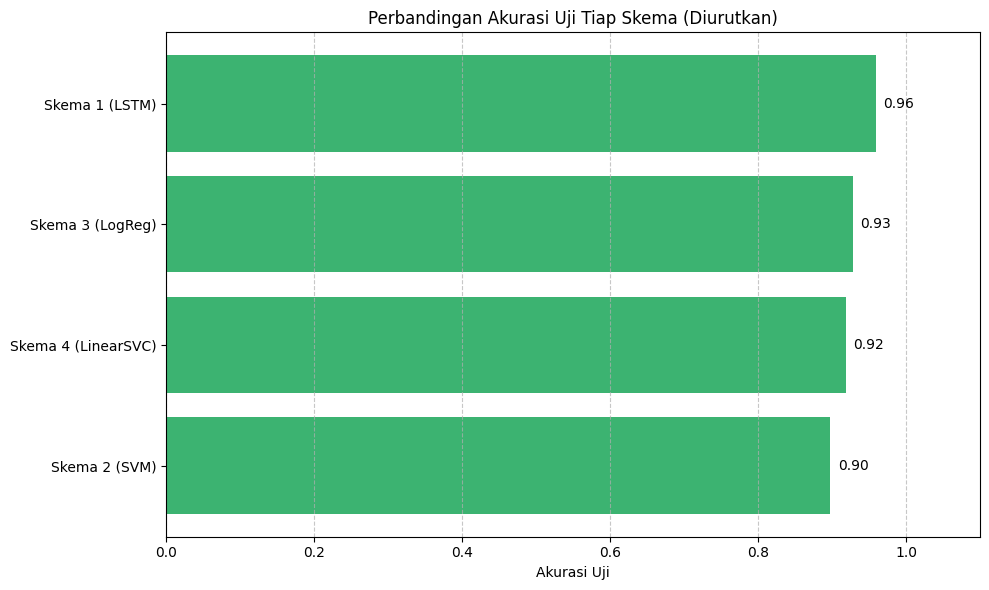

In [30]:
# Akurasi uji dari masing-masing model (urut sesuai skema)
akurasi_test = [test_acc_1, test_acc_2, test_acc_3, test_acc_4]
skema_labels = ['Skema 1 (LSTM)', 'Skema 2 (SVM)', 'Skema 3 (LogReg)', 'Skema 4 (LinearSVC)']

# Buat DataFrame dari skema dan akurasinya
df_akurasi = pd.DataFrame({
    'Skema': skema_labels,
    'Akurasi Uji': akurasi_test
})

# Urutkan berdasarkan akurasi uji
df_sorted = df_akurasi.sort_values(by='Akurasi Uji', ascending=False)

# Tampilkan tabel yang sudah diurutkan
print("=== Tabel Perbandingan Akurasi Uji ===")
print(df_sorted)

# Visualisasi grafik batang horizontal
plt.figure(figsize=(10, 6))
bars = plt.barh(df_sorted['Skema'], df_sorted['Akurasi Uji'], color='mediumseagreen')

# Tambahkan nilai akurasi di ujung bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=10)

plt.xlabel('Akurasi Uji')
plt.title('Perbandingan Akurasi Uji Tiap Skema (Diurutkan)')
plt.xlim(0, 1.1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


### Memilih Model Terbaik

In [34]:
import pickle
import os

# Path folder penyimpanan
save_path = "/content/drive/MyDrive/Dicoding/Project Analisis Sentimen"
os.makedirs(save_path, exist_ok=True)

# Simpan model LSTM (.keras format baru)
model.save(os.path.join(save_path, "model_lstm.keras"))

# Simpan tokenizer
with open(os.path.join(save_path, "tokenizer_lstm.pkl"), "wb") as f:
    pickle.dump(tokenizer, f)

# Simpan label encoder
with open(os.path.join(save_path, "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

### Inference Contoh Ulasan

In [37]:
from tensorflow.keras.models import load_model

# Load model
model = load_model('/content/drive/MyDrive/Dicoding/Project Analisis Sentimen/model_lstm.keras')

# Load tokenizer
with open('/content/drive/MyDrive/Dicoding/Project Analisis Sentimen/tokenizer_lstm.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load label encoder
with open('/content/drive/MyDrive/Dicoding/Project Analisis Sentimen/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

def predict_sentiment(text):
    # Preprocessing
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=300)

    # Predict
    pred = model.predict(padded)
    label = np.argmax(pred, axis=1)
    result = label_encoder.inverse_transform(label)
    print("Hasil prediksi:", result[0])

predict_sentiment("Saya sangat puas dengan kualitas barang dan pelayanannya.")
predict_sentiment("Pelayanannya jelek.")
predict_sentiment("Pengirimannya standar aja.")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamax', because it has 40 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Hasil prediksi: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Hasil prediksi: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Hasil prediksi: neutral
